# Presentación en PDF

https://drive.google.com/file/d/1cLGbW9LqhU7jJF6Nf2aZShVIsdyYfDII/view?usp=drive_link

# Dashboard

https://public.tableau.com/views/CallMeMaybe_17437011220060/Dashboard1?:language=es-ES&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link

# Referencias

- https://cienciadedatos.net/documentos/pystats02-kernel-density-estimation-kde-python
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.pie.html
- https://stackoverflow.com/
- https://www.statology.org/pandas-t-test/
- https://cienciadedatos.net/documentos/pystats10-t-test-python

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores con oportunidades de mejora (bajo desempeño). Se considera que un operador con bajo desempeño, si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de bajo desempeño.

## 1. Definir el objetivo

**¿Qué queremos conseguir y por qué?**  
Identificar operadores ineficaces para ayudar a los supervisores a mejorar el desempeño del equipo de atención y llamadas.

**¿A quién le interesa lo que produces?**  
A los supervisores/as del servicio CallMeMaybe.

**¿Qué decisiones se tomarán?**  
Decisiones sobre capacitación, reasignación de tareas o mejora del rendimiento de los operadores.


## 2. Especificar los detalles

Un operador es ineficaz cuando:

- Tiene muchas llamadas entrantes perdidas (internas o externas).
- Tiene tiempos de espera prolongados para las llamadas entrantes.
- Realiza pocas llamadas salientes si tiene asignada esa responsabilidad.

El cliente solicita también:

- Análisis exploratorio de datos.
- Identificación de operadores ineficaces.
- Pruebas de hipótesis estadísticas.
- Dashboards interactivos.
- Documentación de fuentes consultadas.
- Presentación de resultados en PDF.


## 3. Etapas obligatorias de análisis

### Preprocesamiento
- Estudiar valores nulos y decidir si eliminarlos o rellenarlos.
- Verificar y convertir tipos de datos donde sea necesario.
- Eliminar duplicados si es que no afectan a las métricas.
- Renombrar columnas si es necesario.


### Análisis exploratorio
- Obtener las estadísticas generales de llamadas.
- Generar un histograma de duración de llamadas.
- Generar un pie chart de participación de llamadas internas vs externas.
- Obener las llamadas por día.
- Segmentar por tipo de llamada (interna, externa, entrante, saliente).


### Identificación de operadores ineficaces

### Prueba las hipótesis estadísticas

## 4. Conclusiones

# Preprocesamiento

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
import ipywidgets as widgets
from IPython.display import display, clear_output

In [4]:
#Cargar los datos
raw_calls = pd.read_csv('datasets/telecom_dataset_us.csv')
raw_clients = pd.read_csv('datasets/telecom_clients_us.csv')

In [5]:
#Crear copias limpias para análisis
clean_calls = raw_calls.copy()
clean_clients = raw_clients.copy()

In [6]:
#Conversión de fechas
to_datetime_cols = ['date']
for col in to_datetime_cols:
    clean_calls[col] = pd.to_datetime(clean_calls[col])
clean_clients['date_start'] = pd.to_datetime(clean_clients['date_start'])

In [7]:
#Revisión de nulos
print("Valores nulos en llamadas:")
print(clean_calls.isnull().sum())
print("\nValores nulos en clientes:")
print(clean_clients.isnull().sum())

Valores nulos en llamadas:
user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

Valores nulos en clientes:
user_id        0
tariff_plan    0
date_start     0
dtype: int64


In [8]:
#Conversión de tipos
clean_calls['operator_id'] = clean_calls['operator_id'].astype('Int64')

In [9]:
#Verificamos si hay duplicados en cada dataset limpio
print("Duplicados en clean_calls:", clean_calls.duplicated().sum())
print("Duplicados en clean_clients:", clean_clients.duplicated().sum())

Duplicados en clean_calls: 4900
Duplicados en clean_clients: 0


In [10]:
# Eliminamos duplicados si existen (por precaución)
clean_calls = clean_calls.drop_duplicates()
clean_clients = clean_clients.drop_duplicates()

In [11]:
print("Duplicados en clean_calls:", clean_calls.duplicated().sum())
print("Duplicados en clean_clients:", clean_clients.duplicated().sum())

Duplicados en clean_calls: 0
Duplicados en clean_clients: 0


In [12]:
#Limpieza de registros nulos relevantes
clean_calls = clean_calls[~clean_calls['operator_id'].isna()]  # Excluir llamadas sin operador asignado
clean_calls['internal'] = clean_calls['internal'].fillna(False)
clean_calls['internal'] = clean_calls['internal'].infer_objects()  #Esta línea se agregó para evitar un warning sobre el uso de fillna

C:\Users\Javi\AppData\Local\Temp\ipykernel_51596\960630836.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clean_calls['internal'] = clean_calls['internal'].fillna(False)


Observaciones:
- Las llamadas sin operador asignado (operator_id nulo) corresponden principalmente a llamadas entrantes que nunca fueron atendidas o asignadas a un operador específico.
- Dado que el análisis busca evaluar el desempeño individual de operadores, estas llamadas no pueden ser atribuidas a ningún operador y por lo tanto se excluyen del análisis.
- Los valores nulos en la columna 'internal' sólo aparecen en llamadas entrantes. Asumimos que dichos registros no son llamadas internas, ya que la categoría sólo aplica a llamadas entre operadores dentro de la misma cuenta. Por ello, los nulos son reemplazados por False.

# Análisis exploratorio de datos

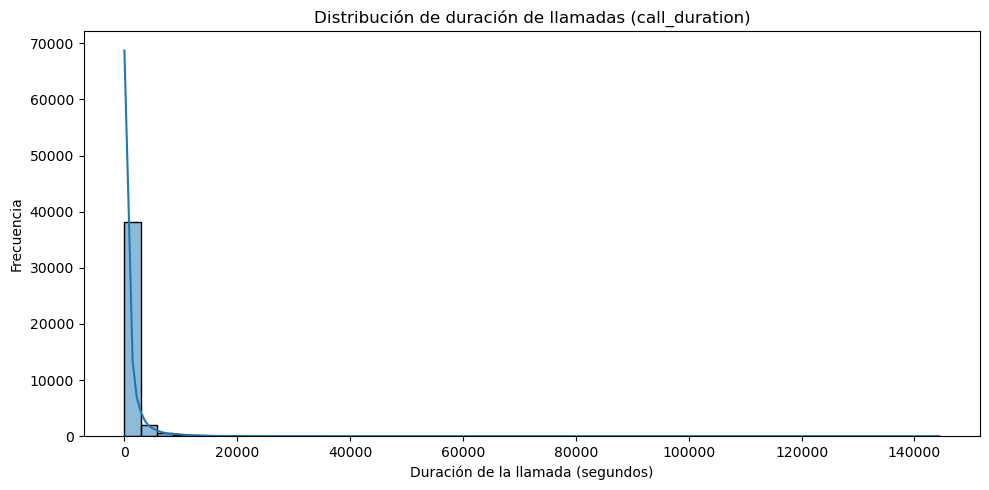

In [13]:
#Distribución de duración de llamadas (sin incluir espera)
plt.figure(figsize=(10, 5))
sns.histplot(clean_calls['call_duration'], bins=50, kde=True)
plt.title('Distribución de duración de llamadas (call_duration)')
plt.xlabel('Duración de la llamada (segundos)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

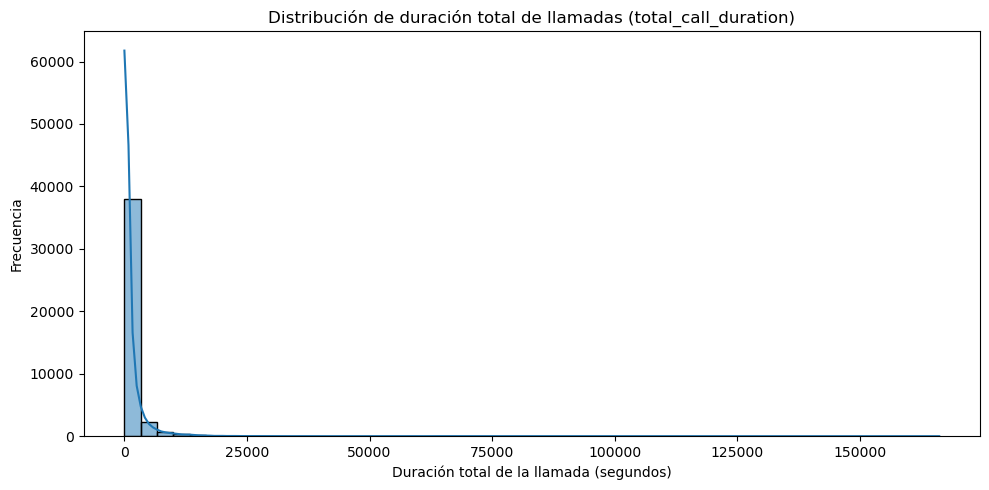

In [14]:
#Distribución de duración total de llamadas (incluyendo espera)
plt.figure(figsize=(10, 5))
sns.histplot(clean_calls['total_call_duration'], bins=50, kde=True)
plt.title('Distribución de duración total de llamadas (total_call_duration)')
plt.xlabel('Duración total de la llamada (segundos)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

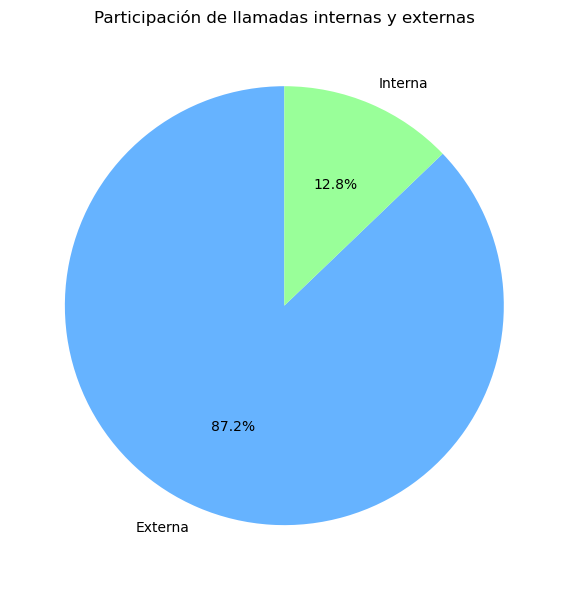

In [15]:
#Participación de llamadas internas vs externas
plt.figure(figsize=(6, 6))
internal_counts = clean_calls['internal'].value_counts()
internal_labels = ['Externa', 'Interna']
plt.pie(internal_counts, labels=internal_labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99'])
plt.title('Participación de llamadas internas y externas')
plt.tight_layout()
plt.show()

**Observaciones:**
- La mayoría de las llamadas son internas, es decir, entre los operadores de un cliente.

In [16]:
#Estadísticas generales de llamadas
print("Estadísticas generales de duración de llamadas:")
print(clean_calls[['call_duration', 'total_call_duration']].describe())

Estadísticas generales de duración de llamadas:
       call_duration  total_call_duration
count   41546.000000         41546.000000
mean     1009.769172          1321.592813
std      4064.106117          4785.978633
min         0.000000             0.000000
25%         0.000000            67.000000
50%       106.000000           288.000000
75%       770.000000          1104.000000
max    144395.000000        166155.000000


date
2019-08-02 00:00:00+03:00       19
2019-08-03 00:00:00+03:00       27
2019-08-04 00:00:00+03:00        4
2019-08-05 00:00:00+03:00      183
2019-08-06 00:00:00+03:00      184
                             ...  
2019-11-24 00:00:00+03:00     3333
2019-11-25 00:00:00+03:00    13819
2019-11-26 00:00:00+03:00    13250
2019-11-27 00:00:00+03:00    12893
2019-11-28 00:00:00+03:00    12501
Name: calls_count, Length: 118, dtype: int64

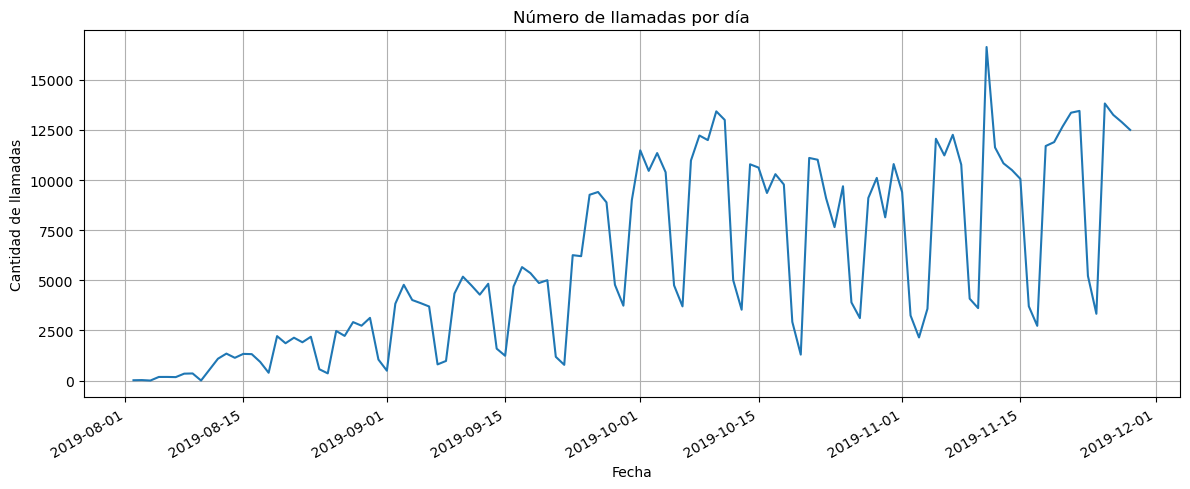

In [17]:
#Llamadas por día
calls_per_day = clean_calls.groupby('date')['calls_count'].sum()
display(calls_per_day)
plt.figure(figsize=(12, 5))
calls_per_day.plot()
plt.title('Número de llamadas por día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de llamadas')
plt.grid(True)
plt.tight_layout()
plt.show()

**Observación:**
- Del 1 de octubre a finales de noviembre se observan más de 10 mil llamadas por día. Puede deberse a la temporada de fiestas.
- Aproximadamente cada 7 días se observa una caída abrupta en las llamadas por día.

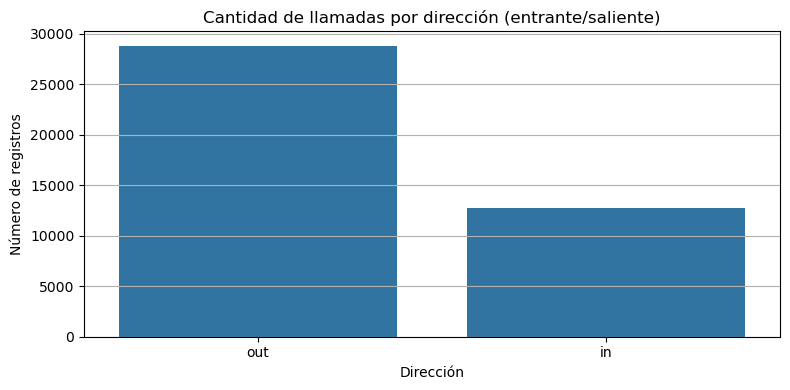

In [18]:
#Segmentación por tipo de llamada (entrante vs saliente)
plt.figure(figsize=(8, 4))
sns.countplot(data=clean_calls, x='direction')
plt.title('Cantidad de llamadas por dirección (entrante/saliente)')
plt.xlabel('Dirección')
plt.ylabel('Número de registros')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Observaciones:**
- La mayoría de las llamadas son salientes. En este punto podríamos afirmar que los operadores están haciendo suficientes llamadas.

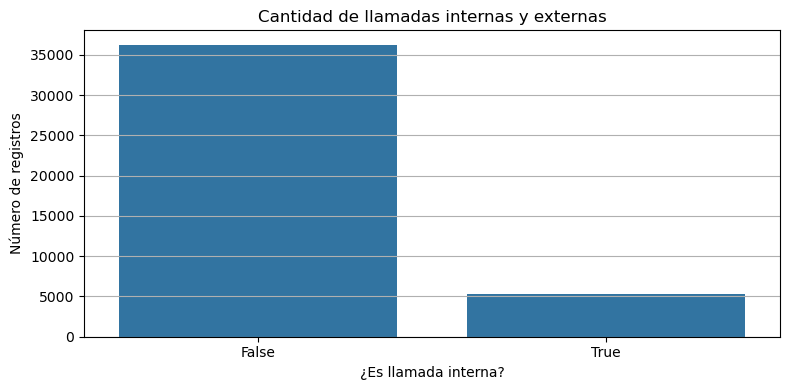

In [19]:
#Segmentación por llamadas internas y externas
plt.figure(figsize=(8, 4))
sns.countplot(data=clean_calls, x='internal')
plt.title('Cantidad de llamadas internas y externas')
plt.xlabel('¿Es llamada interna?')
plt.ylabel('Número de registros')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Observaciones:**
- La mayoría de las llamadas son externas, lo que indica que la carga principal de trabajo está orientada al cliente o usuarios fuera de la organización.
- Las llamadas internas podrían estar enfocadas en coordinación o soporte entre áreas dentro de la organización.
- Esta diferencia sugiere que la mayor parte de las llamadas están enfocadas al cliente.

# Identificación de operadores ineficaces

In [20]:
#Resumen por operador
operator_stats = clean_calls.groupby('operator_id').agg({
    'calls_count': 'sum',
    'call_duration': 'sum',
    'total_call_duration': 'sum',
    'is_missed_call': 'sum',
    'direction': lambda x: (x == 'out').sum()
}).rename(columns={'calls_count': 'total_calls',
                    'call_duration': 'total_call_duration_no_wait',
                    'total_call_duration': 'total_call_duration_with_wait',
                    'is_missed_call': 'missed_calls',
                    'direction': 'outgoing_calls'})
display(operator_stats)

,total_calls,total_call_duration_no_wait,total_call_duration_with_wait,missed_calls,outgoing_calls
operator_id,,,,,
879896,930,63862,76137,47,96
879898,7313,257391,361288,89,170
880020,45,2245,2525,6,13
880022,197,15147,18925,29,62
880026,2232,153326,175526,87,164
...,...,...,...,...,...
972410,77,3777,5275,2,4
972412,61,3498,4548,2,4
972460,51,1218,1838,3,6


In [21]:
#Calcular métricas adicionales por operador
operator_stats['avg_wait_time'] = (operator_stats['total_call_duration_with_wait'] - operator_stats['total_call_duration_no_wait']) / operator_stats['total_calls']
operator_stats['missed_call_rate'] = operator_stats['missed_calls'] / operator_stats['total_calls']
operator_stats['outgoing_call_ratio'] = operator_stats['outgoing_calls'] / operator_stats['total_calls']
display(operator_stats)

,total_calls,total_call_duration_no_wait,total_call_duration_with_wait,missed_calls,outgoing_calls,avg_wait_time,missed_call_rate,outgoing_call_ratio
operator_id,,,,,,,,
879896,930,63862,76137,47,96,13.198925,0.050538,0.103226
879898,7313,257391,361288,89,170,14.207165,0.012170,0.023246
880020,45,2245,2525,6,13,6.222222,0.133333,0.288889
880022,197,15147,18925,29,62,19.177665,0.147208,0.314721
880026,2232,153326,175526,87,164,9.946237,0.038978,0.073477
...,...,...,...,...,...,...,...,...
972410,77,3777,5275,2,4,19.454545,0.025974,0.051948
972412,61,3498,4548,2,4,17.213115,0.032787,0.065574
972460,51,1218,1838,3,6,12.156863,0.058824,0.117647


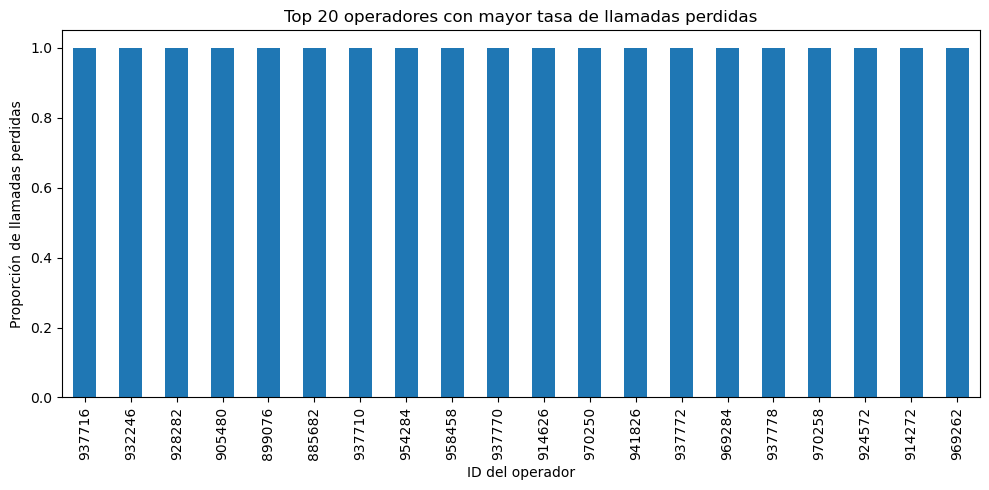

In [22]:
#Operadores con más llamadas perdidas
plt.figure(figsize=(10, 5))
operator_stats['missed_call_rate'].sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Top 20 operadores con mayor tasa de llamadas perdidas')
plt.xlabel('ID del operador')
plt.ylabel('Proporción de llamadas perdidas')
plt.tight_layout()
plt.show()

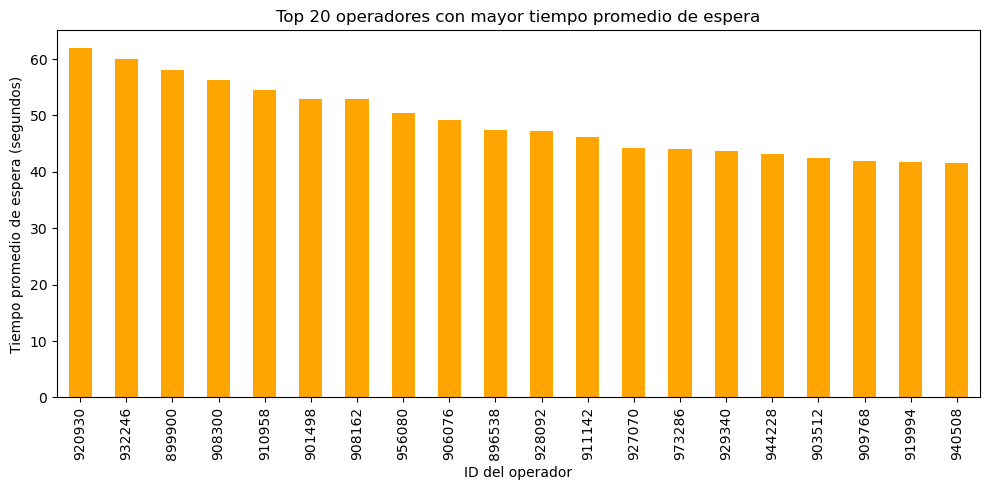

In [23]:
#Operadores con mayor tiempo de espera promedio
plt.figure(figsize=(10, 5))
operator_stats['avg_wait_time'].sort_values(ascending=False).head(20).plot(kind='bar', color='orange')
plt.title('Top 20 operadores con mayor tiempo promedio de espera')
plt.xlabel('ID del operador')
plt.ylabel('Tiempo promedio de espera (segundos)')
plt.tight_layout()
plt.show()

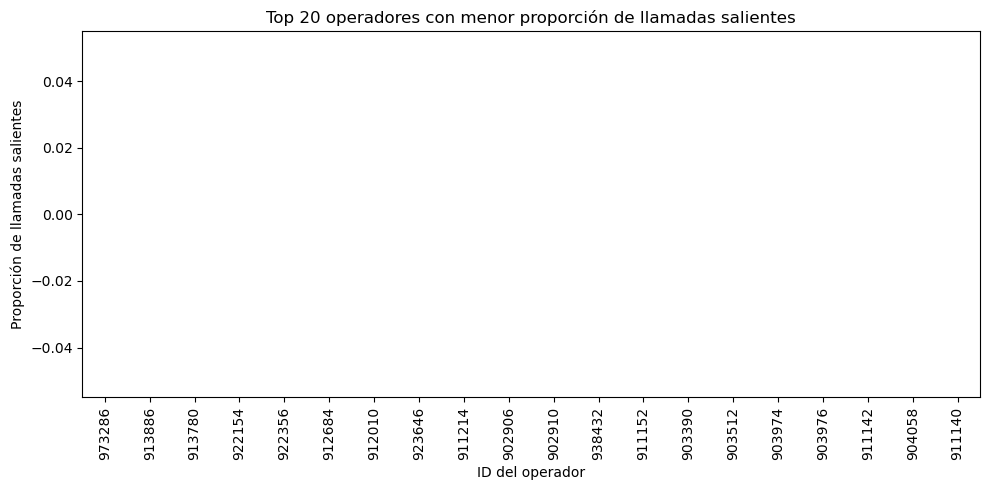

In [24]:
#Operadores con baja proporción de llamadas salientes
plt.figure(figsize=(10, 5))
operator_stats['outgoing_call_ratio'].sort_values().head(20).plot(kind='bar', color='green')
plt.title('Top 20 operadores con menor proporción de llamadas salientes')
plt.xlabel('ID del operador')
plt.ylabel('Proporción de llamadas salientes')
plt.tight_layout()
plt.show()

Observaciones:

1. Tasa de llamadas perdidas
   - Se identificaron operadores cuya tasa de llamadas perdidas supera significativamente el promedio.
   - Estos operadores representan un riesgo para la eficiencia del sistema, ya que no están atendiendo una parte importante de las llamadas entrantes.

2. Tiempo promedio de espera alto
   - Algunos operadores tienen tiempos de espera promedio considerablemente mayores que el resto.
   - Esto puede reflejar baja velocidad de respuesta o saturación de su canal, y afecta directamente la experiencia del usuario.

3. Poca proporción de llamadas salientes
   - Se detectaron operadores con una actividad mínima en llamadas salientes.
   - Si se espera que estos operadores realicen llamadas activas, este comportamiento puede interpretarse como baja productividad o falta de cumplimiento de funciones asignadas.

4. Identificación visual y métrica
   - Las visualizaciones ayudan a destacar rápidamente a los 20 operadores más ineficaces en cada dimensión (llamadas perdidas, tiempo de espera, actividad saliente).
   - Las métricas calculadas por operador permiten construir un sistema de alerta o ranking interno para detectar y mejorar el desempeño.

# Pruebas estadísticas para comparar operadores eficaces vs. ineficaces

Se eligieron los siguientes percentiles para definir umbrales y clasificar a los operadores ineficaces:
1. 90 percentil (top 10%) para:
   - avg_wait_time (tiempo promedio de espera)
   - missed_call_rate (tasa de llamadas perdidas)

2. 10 percentil (bottom 10%) para:
   - outgoing_call_ratio (proporción de llamadas salientes)

- El objetivo es identificar a los operadores con peor desempeño relativo.
- El percentil 90 para métricas negativas (espera y llamadas perdidas) selecciona el 10% de operadores con peores valores.
- El percentil 10 para métricas positivas (actividad saliente) selecciona el 10% con menor desempeño.
- Usar el 90% permite detectar ineficiencia sin que sea excesivamente estricto.

In [25]:
# Definir umbrales para clasificar operadores ineficaces
umbral_espera = operator_stats['avg_wait_time'].quantile(0.9)
umbral_perdidas = operator_stats['missed_call_rate'].quantile(0.9)
umbral_salientes = operator_stats['outgoing_call_ratio'].quantile(0.1)
display(umbral_espera)
display(umbral_perdidas)
display(umbral_salientes)

24.870227885322223

0.25

0.0

In [26]:
# Crear columna binaria: 1 = ineficaz, 0 = eficaz
operator_stats['ineficaz'] = (
    (operator_stats['avg_wait_time'] >= umbral_espera) |
    (operator_stats['missed_call_rate'] >= umbral_perdidas) |
    (operator_stats['outgoing_call_ratio'] <= umbral_salientes)
).astype(int)
display(operator_stats)

,total_calls,total_call_duration_no_wait,total_call_duration_with_wait,missed_calls,outgoing_calls,avg_wait_time,missed_call_rate,outgoing_call_ratio,ineficaz
operator_id,,,,,,,,,
879896,930,63862,76137,47,96,13.198925,0.050538,0.103226,0
879898,7313,257391,361288,89,170,14.207165,0.012170,0.023246,0
880020,45,2245,2525,6,13,6.222222,0.133333,0.288889,0
880022,197,15147,18925,29,62,19.177665,0.147208,0.314721,0
880026,2232,153326,175526,87,164,9.946237,0.038978,0.073477,0
...,...,...,...,...,...,...,...,...,...
972410,77,3777,5275,2,4,19.454545,0.025974,0.051948,0
972412,61,3498,4548,2,4,17.213115,0.032787,0.065574,0
972460,51,1218,1838,3,6,12.156863,0.058824,0.117647,0


**Hipótesis nula (H₀):**
El tiempo promedio de espera es igual entre operadores eficaces e ineficaces.

**Hipótesis alternativa (H₁):**
El tiempo promedio de espera es diferente entre operadores eficaces e ineficaces.

In [27]:
# Comparar tiempo de espera promedio entre grupos
inef = operator_stats[operator_stats['ineficaz'] == 1]['avg_wait_time']
efic = operator_stats[operator_stats['ineficaz'] == 0]['avg_wait_time']
print(inef)
print(efic)

operator_id
881278     3.900000
882476    31.666667
882478    20.750000
882680    16.070707
883018     7.500000
            ...    
971100     8.666667
971102    17.789474
971354    14.000000
973120     6.666667
973286    44.000000
Name: avg_wait_time, Length: 363, dtype: float64
operator_id
879896    13.198925
879898    14.207165
880020     6.222222
880022    19.177665
880026     9.946237
            ...    
970252    16.833333
972408     7.500000
972410    19.454545
972412    17.213115
972460    12.156863
Name: avg_wait_time, Length: 729, dtype: float64


In [28]:
stat, pval, _ = ttest_ind(inef, efic, usevar='unequal')
print("Comparación de tiempo promedio de espera")
print("Estadístico t:", stat)
print("Valor p:", pval)
if pval < 0.05:
    print("Diferencia significativa entre operadores eficaces e ineficaces.")
else:
    print("No hay diferencia significativa en el tiempo de espera.")

Comparación de tiempo promedio de espera
Estadístico t: 5.719759065766564
Valor p: 2.0060269424044118e-08
Diferencia significativa entre operadores eficaces e ineficaces.


**Hipótesis nula (H₀):**
La tasa de llamadas perdidas es igual entre operadores eficaces e ineficaces.

**Hipótesis alternativa (H₁):**
La tasa de llamadas perdidas es diferente entre operadores eficaces e ineficaces.

In [29]:
# Comparar tasa de llamadas perdidas entre grupos
inef_perdidas = operator_stats[operator_stats['ineficaz'] == 1]['missed_call_rate']
efic_perdidas = operator_stats[operator_stats['ineficaz'] == 0]['missed_call_rate']
display(inef_perdidas)
display(efic_perdidas)

operator_id
881278    0.350000
882476    0.000000
882478    0.250000
882680    0.030303
883018    0.500000
            ...   
971100    0.000000
971102    0.000000
971354    0.000000
973120    0.333333
973286    0.000000
Name: missed_call_rate, Length: 363, dtype: float64

operator_id
879896    0.050538
879898    0.012170
880020    0.133333
880022    0.147208
880026    0.038978
            ...   
970252    0.166667
972408    0.166667
972410    0.025974
972412    0.032787
972460    0.058824
Name: missed_call_rate, Length: 729, dtype: float64

In [30]:
stat, pval, _ = ttest_ind(inef_perdidas, efic_perdidas, usevar='unequal')
print("Comparación de tasa de llamadas perdidas")
print("Estadístico t:", stat)
print("Valor p:", pval)
if pval < 0.05:
    print("Diferencia significativa entre operadores eficaces e ineficaces.")
else:
    print("No hay diferencia significativa en la tasa de llamadas perdidas.")

Comparación de tasa de llamadas perdidas
Estadístico t: 6.894212366213768
Valor p: 2.2664437902477418e-11
Diferencia significativa entre operadores eficaces e ineficaces.


**Hipótesis nula (H₀):**
La proporción de llamadas salientes es igual entre operadores eficaces e ineficaces.

**Hipótesis alternativa (H₁):**
La proporción de llamadas salientes es diferente entre operadores eficaces e ineficaces.

In [31]:
# Comparar proporción de llamadas salientes entre grupos
inef_salientes = operator_stats[operator_stats['ineficaz'] == 1]['outgoing_calls'].sum()
efic_salientes = operator_stats[operator_stats['ineficaz'] == 0]['outgoing_calls'].sum()

total_inef = operator_stats[operator_stats['ineficaz'] == 1]['total_calls'].sum()
total_efic = operator_stats[operator_stats['ineficaz'] == 0]['total_calls'].sum()

count = np.array([inef_salientes, efic_salientes])
nobs = np.array([total_inef, total_efic])

stat, pval = proportions_ztest(count, nobs)
print("Comparación de proporción de llamadas salientes")
print("Estadístico Z:", stat)
print("Valor p:", pval)
if pval < 0.05:
    print("Diferencia significativa en la proporción de llamadas salientes entre los grupos.")
else:
    print("No hay diferencia significativa en la proporción de llamadas salientes entre los grupos.")


Comparación de proporción de llamadas salientes
Estadístico Z: 5.460159005563372
Valor p: 4.7570834032838074e-08
Diferencia significativa en la proporción de llamadas salientes entre los grupos.


# Conclusiones

- Se llevó a cabo un análisis integral de las llamadas realizadas a través del sistema CallMeMaybe, abarcando tanto llamadas internas como externas, entrantes y salientes.
- Se realizó una limpieza y estructuración cuidadosa de los datos, garantizando que el análisis se centrara exclusivamente en operadores con actividad atribuible.
- El análisis exploratorio reveló patrones en duración, frecuencia y tipo de llamadas, permitiendo comprender mejor la dinámica operativa de los usuarios del sistema.
- Se definieron métricas clave por operador: tasa de llamadas perdidas, tiempo promedio de espera y proporción de llamadas salientes.
- Se identificaron operadores ineficaces con base en umbrales de percentiles altos o bajos en estas métricas.
- Las pruebas estadísticas confirmaron diferencias significativas entre los operadores eficaces e ineficaces, validando empíricamente la segmentación.
- Se detectaron patrones estacionales en el volumen de llamadas diarias, lo cual podría estar relacionado con horarios pico de atención o eventos particulares en la operación.
- La distribución de duración de llamadas mostró una alta concentración de interacciones cortas, con presencia de valores atípicos que pueden ser monitoreados como posibles anomalías operativas o clientes especiales.
- A pesar de que muchos operadores se desempeñan de manera eficiente, una minoría concentró los peores indicadores, lo cual representa una oportunidad clara para intervenciones específicas (formación, reasignación de tareas o evaluación de carga).
- El análisis por tipo de llamada (interna vs externa, entrante vs saliente) permitió identificar perfiles distintos de operadores, algunos más enfocados en soporte interno y otros con roles claramente orientados a clientes externos.
- Estas conclusiones permiten no sólo tomar acciones correctivas, sino también sentar las bases para modelos predictivos de desempeño futuro y optimización de recursos humanos en telecomunicaciones.